In [ ]:
pip install pytesseract

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/MyDrive/sign_data" -d "/content/"


In [ ]:
import os
import glob
import pandas as pd
from random import sample
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/sign_data/train_data.csv", header=None)
test_df = pd.read_csv("/content/drive/MyDrive/sign_data/test_data.csv", header=None)

In [ ]:
train_dir = "/content/drive/MyDrive/sign_data/train"
test_dir = "/content/drive/MyDrive/sign_data/test"

In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
import pandas as pd
from PIL import Image
import urllib
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

In [ ]:
class DataLoader:
  #constructor
  def __init__(self, dataset, batch_size,dir):
    self.dataset = dataset
    self.batch_size = batch_size
    self.dir = dir
  #shuffler
  def shuffle(self):
    return self.dataset.sample(frac=1)
  #generator
  def datagen(self):
    num_samples = len(self.dataset)
    while True:
        # shuffling the samples
        self.dataset = self.shuffle()
        for batch in range(1, num_samples, self.batch_size):
            image1_batch_samples = self.dir + "/" + self.dataset.iloc[:, 0][batch:batch + self.batch_size]
            image2_batch_samples = self.dir + "/" + self.dataset.iloc[:, 1][batch:batch + self.batch_size]
            label_batch_samples = self.dataset.iloc[:, 2][batch:batch + self.batch_size]
            Image1, Image2, Label = [], [], []
            for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):
                # append them to Images directly
                image1_data = Image.open(image1)
                image2_data = Image.open(image2)
                # resizing the images
                image1_data = image1_data.resize((112, 112))
                image2_data = image2_data.resize((112, 112))
                # converting to array
                image1_data = img_to_array(image1_data)
                image2_data = img_to_array(image2_data)
                Image1.append(image1_data)
                Image2.append(image2_data)
                Label.append(label)
            # convert each list to numpy arrays to ensure that they get processed by fit function
            Image1 = np.asarray(Image1).astype(np.float32)
            Image2 = np.asarray(Image2).astype(np.float32)
            Label = np.asarray(Label).astype(np.float32)
            yield [Image1, Image2], Label

In [ ]:
train_set, val_set = train_test_split(train_df, test_size=0.25)

In [ ]:
train_gen= DataLoader(train_set,1024,train_dir)
val_gen = DataLoader(val_set,1024,train_dir)

In [ ]:
train_batch = next(train_gen.datagen())
print("Train batch images shape:", train_batch[0][0].shape, train_batch[0][1].shape)
print("Train batch labels shape:", train_batch[1].shape)

Train batch images shape: (1024, 112, 112, 3) (1024, 112, 112, 3)
Train batch labels shape: (1024,)


In [ ]:
def custom_siamese_model(input_shape):
    input1 = Input(input_shape)
    input2 = Input(input_shape)

    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))

    # Call the model with the inputs
    embedding1 = model(input1)
    embedding2 = model(input2)

    loss_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    manhattan_distance = loss_layer([embedding1, embedding2])
    output = Dense(1, activation='sigmoid')(manhattan_distance)
    network = Model(inputs=[input1, input2], outputs=output)
    return network

In [ ]:
early_stopper =  EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=1)
custom_callback = [early_stopper]

In [ ]:
model = custom_siamese_model((112,112,3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128)                  1802016   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 128)                  0         ['sequential[0][0]',      

In [ ]:
optimizer = Adam(lr = 1e-4)
model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

In [ ]:
print("Initializing Training !!")
history = model.fit_generator(
    train_gen.datagen(),
    verbose=1,
    steps_per_epoch=80,  # set appropriate steps_per_epoch
    epochs=3,
    validation_data=val_gen.datagen(),
    validation_steps=100,  # set appropriate validation_steps
    callbacks=custom_callback
)

Initializing Training !!


<ipython-input-14-57b028692b56>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/3
80/80 [==============================] - 5797s 73s/step - loss: 2.0529 - accuracy: 0.6694 - val_loss: 0.5020 - val_accuracy: 0.7516
Epoch 2/3
80/80 [==============================] - 5835s 73s/step - loss: 0.2924 - accuracy: 0.8864 - val_loss: 0.3322 - val_accuracy: 0.8692
Epoch 3/3
80/80 [==============================] - 5700s 72s/step - loss: 0.1225 - accuracy: 0.9570 - val_loss: 0.2052 - val_accuracy: 0.9455


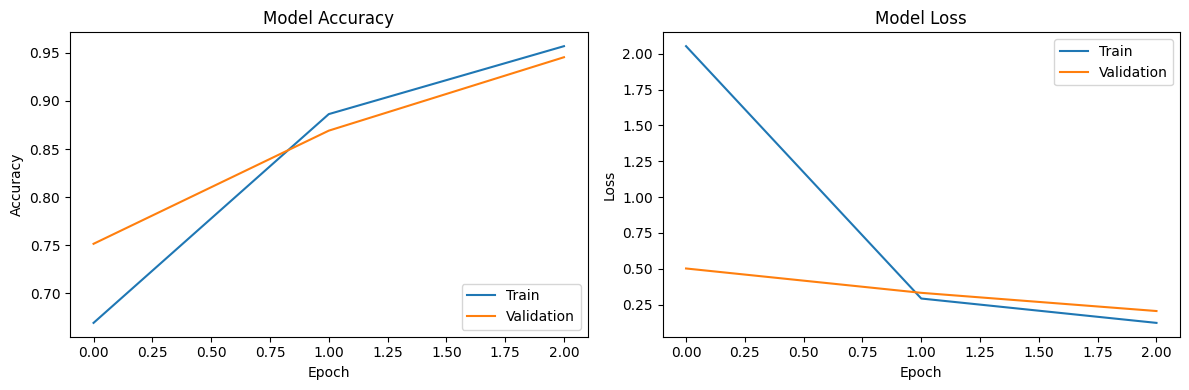

In [ ]:
history_keys = history.history.keys()

plt.figure(figsize=(12, 4))

# Plot the accuracy curves
if 'accuracy' in history_keys and 'val_accuracy' in history_keys:
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

# Plot the loss curves
if 'loss' in history_keys and 'val_loss' in history_keys:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/Signature_model_new/saved_model_new")

In [ ]:
model.save('signature_verification_Siamese.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 418ms/step
Similarity Score: 0.9995748


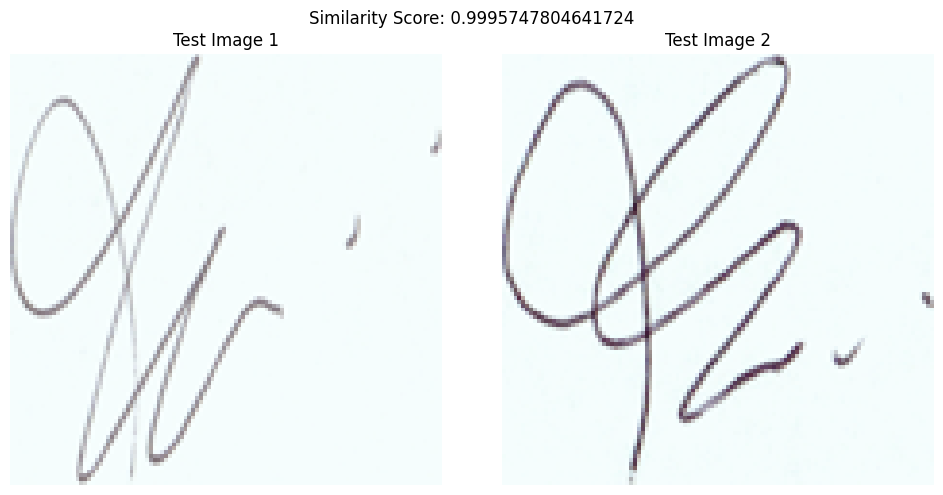

In [ ]:
test_image1_path = '/content/drive/MyDrive/sign_data/test/049/01_049.png'
test_image2_path = '/content/drive/MyDrive/sign_data/test/049_forg/01_0114049.PNG'

# Load and preprocess the test images
test_image1 = Image.open(test_image1_path)
test_image1 = test_image1.resize((112, 112))
test_image1 = img_to_array(test_image1)
test_image1 = np.expand_dims(test_image1, axis=0)
test_image1 = test_image1.astype('float32')

test_image2 = Image.open(test_image2_path)
test_image2 = test_image2.resize((112, 112))
test_image2 = img_to_array(test_image2)
test_image2 = np.expand_dims(test_image2, axis=0)
test_image2 = test_image2.astype('float32')

# Perform inference on the test images
prediction = model.predict([test_image1, test_image2])

# Print the similarity score
similarity_score = prediction[0][0]
print('Similarity Score:', similarity_score)

# Display the test images with the similarity score as legend
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image1[0].astype('uint8'))
plt.title('Test Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(test_image2[0].astype('uint8'))
plt.title('Test Image 2')
plt.axis('off')

plt.suptitle(f'Similarity Score: {similarity_score}', fontsize=12)
plt.tight_layout()
plt.show()